In [1]:
collab_mode = False

if collab_mode:
    # set up tensorflow
    %tensorflow_version 2.x
# imports
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import warnings # This ignore all the warning messages
warnings.filterwarnings('ignore')

from os import path
import os
import time

print(tf.__version__)

2.0.0


In [2]:
root_local_path = os.getcwd()
root_gdrive_path = '/content/drive'
gdrive_project_path = 'My Drive/pp/GSN/FaceGenerator'
checkpoints_path = 'checkpoints'
dataset_path = 'datasets'
dataset_name = "celeb_a"
tensorboard_logs_dir='tensorboard'
download_path = '' # output path for the dataset
generated_images_path = 'generated_images'
dataset_image_size = (28, 28)
run_name = ''
gdrive_mounted = False

In [85]:
def allow_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

# run the line below if you're using local runtime and have GTX > 1660 (this is known bug with tensorflow memory allocation)
# allow_memory_growth()

allow_memory_growth()
print("Getting device name")
tf.test.gpu_device_name()

1 Physical GPUs, 1 Logical GPUs
Getting device name


'/device:GPU:0'

Misc helper functions

In [4]:
def get_time():
    return time.strftime("%d-%m-%Y-_%H-%M-%S") 

# Mount gdrive disk if necessary

In [5]:
if collab_mode:
    from google.colab import drive
    project_path = path.join(root_gdrive_path, gdrive_project_path )
    gdrive_project_path = path.join(root_gdrive_path, gdrive_project_path)
    drive.mount(root_gdrive_path)
    gdrive_mounted = True

def get_base_path():
    if collab_mode:
        return path.join(root_gdrive_path, gdrive_project_path)
    else:
        return root_local_path 

## Import dataset_helpers

In [6]:
if collab_mode:
    path_with_imports = path.join(root_gdrive_path, gdrive_project_path)
    print("Files in path", path_with_imports)
    !ls /content/drive/My\ Drive/pp/GSN/FaceGenerator
    if path_with_imports not in os.sys.path:
        os.sys.path.append(path_with_imports)

import dataset_helpers as ds_helpers

### Download dataset

In [7]:
def download_dataset():
    '''Downloads data to dataset_path/dataset_name directory'''
    if collab_mode:
        download_path = path.join(root_gdrive_path, gdrive_project_path, dataset_path, dataset_name)
    else:
        download_path = path.join(root_local_path, dataset_path, dataset_name)
    
    print('dataset download path is {}'.format(download_path))
    ds_helpers.download_extract('celeba', download_path)

download_dataset()

dataset download path is D:\iswd_2\gsn\laby\FaceGenerator\datasets\celeb_a
Found celeba Data


### Load dataset

In [8]:
download_path = path.join(root_local_path, dataset_path, 'celeb_a')
img_path = path.join(download_path, '1k\\*.jpg')
IMAGE_SIZES = (64, 64)
IMAGE_CHANNELS=3
IMAGES_SHAPE = (*IMAGE_SIZES, IMAGE_CHANNELS)
print(IMAGES_SHAPE)
def process_image(img):
    img = tf.cast(img, tf.float32)/127.5-1 # IMPORTANT, image's pixels are in the range <-1, 1>
    img = tf.image.resize(img, IMAGE_SIZES)
    return img

def load_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    return img

def load_dataset(batch_size, preprocess_images=True, shuffle_size=500, seed=101):
    data = tf.data.Dataset.list_files(img_path, seed=seed)\
        .shuffle(shuffle_size)\
        .map(load_image)
    if preprocess_images:
        data = data.map(process_image)
    return data.batch(batch_size)
    
data = load_dataset(batch_size=100)

(64, 64, 3)


(64, 64, 3) 0.0017558932 0.9879902


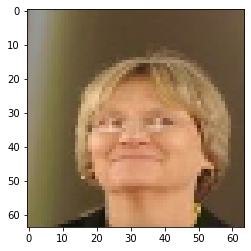

In [9]:
def display_image_from_dataset():
    # Check image
    for batch in data.take(1):
        for img in iter(batch):
            img_ = (img+1)/2
            plt.imshow(img_)
            print(img_.shape, np.min(img_), np.max(img_))
            break
            
display_image_from_dataset()

### Saving functions

In [96]:
def save_generated_image(epoch):
    save_dir = path.join(get_base_path(), generated_images_path)
    if not path.exists(save_dir):
        os.mkdir(save_dir)
    name = path.join(save_dir,
                     run_name,
                     'img_{}_{}.png'.format(epoch, get_time()))
    plt.savefig(name)

def show_images(images, epoch, img_size=12, save_images=False, display_images=False):
    print("saving images with shape", images.shape, "image size", img_size)
    print("image pixels range", np.min(images[0]), np.max(images[0]))
    fig = plt.figure(figsize=(img_size, img_size * 10))

    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i, :, :, :] * 127.5 + 127.5)
        plt.axis('off')

    if save_images:
        save_generated_image(epoch)
    if display_images:
        plt.show()

In [11]:
def save_models(generator, discriminator):
    def save(epoch_number):
        path = get_path()
    return save

In [12]:
log_dir_path = path.join(get_base_path(), tensorboard_logs_dir)
if collab_mode:
    %reload_ext tensorboard

    print('tensorboard log dir {}'.format(log_dir_path))
    %tensorboard --logdir logs
    from tensorboard import notebook
    notebook.list() # View open TensorBoard instances
else:
    print('open tensorboard with command')
    print('tensorboard --logdir {}'.format(log_dir_path))


open tensorboard with command
tensorboard --logdir D:\iswd_2\gsn\laby\FaceGenerator\tensorboard


In [13]:
train_log_dir = 'logs/gradient_tape/' + get_time() + '/train'
test_log_dir = 'logs/gradient_tape/' + get_time() + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    

Loss functions


In [94]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def min_max_discriminator_loss(real_out, gen_out):
    real_loss = bce(tf.ones_like(real_out), real_out)
    gen_loss = bce(tf.zeros_like(gen_out), gen_out)
    return real_loss + gen_loss


def min_max_generator_loss(gen_out):
    return - min_max_discriminator_loss(tf.ones_like(gen_out), gen_out)


def w_discriminator_loss(real_out, gen_out):
    res = - (tf.reduce_mean(real_out) - tf.reduce_mean(gen_out))
    return res


def w_generator_loss(gen_out):
    return - tf.reduce_mean(gen_out)

In [15]:
def print_layers(model):
    for layer in model.layers:
            print(layer.name, ":", layer.input_shape, "->", layer.output_shape)

Generator


In [68]:
class Generator(tf.keras.Model):

    def __init__(self, input_shape, model_name="Generator", **kwargs):
        super(Generator, self).__init__(name=model_name, **kwargs)
#         print("input ", input_shape)
        self.noise_decoder = tf.keras.Sequential([
            # flat
            tf.keras.layers.Dense(1024, input_shape=input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Reshape([16, 16, 256]),
            # conv without stride (16x16)
            tf.keras.layers.Conv2D(256, 5, 1, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            # t_conv with stride (32x32)
            tf.keras.layers.Conv2DTranspose(128, 5, 2, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            # conv without stride (32x32)
            tf.keras.layers.Conv2D(64, 5, 1, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            # t_conv with stride (64x64)
            tf.keras.layers.Conv2DTranspose(32, 5, 2, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            # conv without stride
            tf.keras.layers.Conv2D(3, (1, 1), 1, 'same')
        ])
        print_layers(self.noise_decoder)

    def call(self, noise, training):
        return self.noise_decoder(noise)
    
    def summary(self):
        self.noise_decoder.summary()

generator_input_shape = (64, 3)
generator = Generator(input_shape=generator_input_shape)
# generator.build((None, *generator_input_shape))
generator.summary()

# generator = Generator(input_shape=IMAGES_SHAPE)
# generator.build((None, *IMAGES_SHAPE))
# generator.summary()
# tf.keras.utils.plot_model(generator, "gen.png")

dense_9 : (None, 64, 3) -> (None, 64, 1024)
batch_normalization_63 : (None, 64, 1024) -> (None, 64, 1024)
re_lu_71 : (None, 64, 1024) -> (None, 64, 1024)
reshape_10 : (None, 64, 1024) -> (None, 16, 16, 256)
conv2d_44 : (None, 16, 16, 256) -> (None, 16, 16, 256)
batch_normalization_64 : (None, 16, 16, 256) -> (None, 16, 16, 256)
re_lu_72 : (None, 16, 16, 256) -> (None, 16, 16, 256)
conv2d_transpose_20 : (None, 16, 16, 256) -> (None, 32, 32, 128)
batch_normalization_65 : (None, 32, 32, 128) -> (None, 32, 32, 128)
re_lu_73 : (None, 32, 32, 128) -> (None, 32, 32, 128)
conv2d_45 : (None, 32, 32, 128) -> (None, 32, 32, 64)
batch_normalization_66 : (None, 32, 32, 64) -> (None, 32, 32, 64)
re_lu_74 : (None, 32, 32, 64) -> (None, 32, 32, 64)
conv2d_transpose_21 : (None, 32, 32, 64) -> (None, 64, 64, 32)
batch_normalization_67 : (None, 64, 64, 32) -> (None, 64, 64, 32)
re_lu_75 : (None, 64, 64, 32) -> (None, 64, 64, 32)
conv2d_46 : (None, 64, 64, 32) -> (None, 64, 64, 3)
Model: "sequential_17"
_

Discriminator


In [65]:
class Discriminator(tf.keras.Model):

    def __init__(self, input_shape, model_name="Discriminator", **kwargs):
        super(Discriminator, self).__init__(name=model_name, **kwargs)

        # since discriminator is for classification it should be robust, thus, add
        # additional regularization like dropout to prevent from pixel attacks
        self.image_encoder = tf.keras.Sequential([
            # conv with stride (32x32)
            tf.keras.layers.Conv2D(64, 5, 2, 'same', input_shape=input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dropout(0.3),
            # conv with stride (16x16x128)
            tf.keras.layers.Conv2D(128, 3, 2, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dropout(0.3),
            # flatten + hidden layer
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dropout(0.3),
            # prediction (LOGITS!)
            tf.keras.layers.Dense(1)
        ])
        print_layers(self.image_encoder)

    def call(self, images, training):
        return self.image_encoder(images)
    
    def summary(self):
        self.image_encoder.summary()

# discriminator = Discriminator(input_shape=IMAGES_SHAPE)
# discriminator.build(input_shape=(None, *IMAGES_SHAPE))
# discriminator.summary()
# start_training()

Noise generator


In [59]:
class NoiseGenerator(tf.keras.layers.Layer):

    def __init__(self, num_classes, distribution_size):
        super().__init__()
        self.distribution_size = distribution_size
        # self.data_distributions = self.add_weight(shape=(num_classes, distribution_size), trainable=True)
        # self.data_distributions = tf.tile(tf.range(0, num_classes, dtype=tf.float32)[:, tf.newaxis], [1, distribution_size])
        # TODO:

    def call(self, inputs):
        # dists = tf.nn.embedding_lookup(self.data_distributions, inputs)
        # dists += tf.random.uniform(tf.shape(dists), -0.35, 0.35)
        # return dists
        # TODO
        return tf.random.uniform([tf.shape(inputs)[0], self.distribution_size, 3])
        
    def diverse_distributions_loss(self):
        # TODO
        return None

Training step



In [48]:
def train_step_template(generator, discriminator, noise, d_optim, g_optim, d_loss_f, g_loss_f):

    @tf.function
    def _train_step_template(images):
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            real_out = discriminator(images, True)
            gen_out = discriminator(generator(noise(images), True), True)

            d_loss = d_loss_f(real_out, gen_out)
            g_loss = g_loss_f(gen_out)

        d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
        g_grads = g_tape.gradient(g_loss, generator.trainable_variables + noise.trainable_variables)

        d_optim.apply_gradients(zip(d_grads, discriminator.trainable_variables))
        g_optim.apply_gradients(zip(g_grads, generator.trainable_variables + noise.trainable_variables))

    return _train_step_template


In [88]:
batch_size = 10
train_data = load_dataset(batch_size=batch_size)


Inference step



In [74]:
def gen_step_template(generator, noise):
    @tf.function
    def _gen_step_template(data_shape):
        return tf.clip_by_value(generator(noise(data_shape), False), -1, 1)

    return _gen_step_template

Training

In [97]:
def train(train_step, gen_step, epochs, train_data, save_images=True, display_images=True, checkpoint=None):
    run_name = 'run_{}'.format(get_time())

    for epoch in range(epochs):
        for images in train_data:
            train_step(images)
    
        print('Epoch {0}/{1}'.format(epoch, epochs))
        if (epoch + 1) % 5 == 0 and checkpoint is not None:
            print("Saving checkpoint")
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        generated = gen_step(images)
        show_images(generated, epoch, save_images=save_images, display_images=display_images)

    

Training with Wasserstein loss function

In [90]:
generator_input_shape = (64, 3)
generator = Generator(input_shape=generator_input_shape)
generator.build((None, *generator_input_shape))
generator.summary()

discriminator = Discriminator(input_shape=IMAGES_SHAPE)
discriminator.build(input_shape=(None, *IMAGES_SHAPE))
discriminator.summary()

dense_10 : (None, 64, 3) -> (None, 64, 1024)
batch_normalization_68 : (None, 64, 1024) -> (None, 64, 1024)
re_lu_76 : (None, 64, 1024) -> (None, 64, 1024)
reshape_11 : (None, 64, 1024) -> (None, 16, 16, 256)
conv2d_47 : (None, 16, 16, 256) -> (None, 16, 16, 256)
batch_normalization_69 : (None, 16, 16, 256) -> (None, 16, 16, 256)
re_lu_77 : (None, 16, 16, 256) -> (None, 16, 16, 256)
conv2d_transpose_22 : (None, 16, 16, 256) -> (None, 32, 32, 128)
batch_normalization_70 : (None, 32, 32, 128) -> (None, 32, 32, 128)
re_lu_78 : (None, 32, 32, 128) -> (None, 32, 32, 128)
conv2d_48 : (None, 32, 32, 128) -> (None, 32, 32, 64)
batch_normalization_71 : (None, 32, 32, 64) -> (None, 32, 32, 64)
re_lu_79 : (None, 32, 32, 64) -> (None, 32, 32, 64)
conv2d_transpose_23 : (None, 32, 32, 64) -> (None, 64, 64, 32)
batch_normalization_72 : (None, 64, 64, 32) -> (None, 64, 64, 32)
re_lu_80 : (None, 64, 64, 32) -> (None, 64, 64, 32)
conv2d_49 : (None, 64, 64, 32) -> (None, 64, 64, 3)
Model: "sequential_18"


In [102]:
def start_training():
    noise = NoiseGenerator(10, 64)
    d_optim = tf.optimizers.Adam(1e-4)
    g_optim = tf.optimizers.Adam(1e-4)
    
#     generator.compile(g_optim, g_loss, g_metrics=['accuracy'])
    checkpoint = tf.train.Checkpoint(generator_optimizer=g_optim,
                                     discriminator_optimizer=d_optim,
                                     generator=generator,
                                     discriminator=discriminator)

    train_step = train_step_template(
        generator=generator,
        discriminator=discriminator,
        noise=noise,
        d_optim=d_optim,
        g_optim=g_optim,
        d_loss_f=w_discriminator_loss,
        g_loss_f=w_generator_loss,
    )

    gen_step = gen_step_template(
        generator=generator,
        noise=noise
    )

    train(
        train_step=train_step, 
        gen_step=gen_step, 
        epochs=30,
        train_data=train_data,
        checkpoint=checkpoint
    )

print("Start time")
get_time()
start = time.time()

start_training()

end = time.time()
print("End time")
get_time()
print("time elapsed", end-start)

Start time


AttributeError: 'builtin_function_or_method' object has no attribute 'strftime'